Import things

In [8]:
from itertools import product
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.animation as animation
#import matplotlib.pyplot as plt
import pylab as plt
import torch
import torch.nn.functional as Func
import pandas as pd
import scipy.io
import datetime
import numpy as np
import os
import gc

# get the directory of the notebook
p = os.path.dirname("BF.ipynb")
dir = os.path.abspath(p)

# get the directory of the script... uncomment this if you want to use the script as a standalone file
'''
dir = os.path.dirname(os.path.abspath(__file__))
'''

# Change working directory to the script/notebooks's directory
os.chdir(dir)
print("Changed working directory to:", os.getcwd())

# detect GPU
device = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.backends.cuda.is_available()
    else "cpu"
)

Changed working directory to: /Users/robertdoerner/Documents/Grad/ECE 228 ML for Physical Applications/Project


Read in raw acoustic and positional data, enter basic paramters of the problem

In [9]:
# hyd_pos is hydrophone (x,y) position matrix with shape (21,2)
hyd_pos_y = torch.tensor([
    94.125,
    99.755,
    105.38,
    111.00,
    116.62,
    122.25,
    127.88,
    139.12,
    144.74,
    150.38,
    155.99,
    161.62,
    167.26,
    172.88,
    178.49,
    184.12,
    189.76,
    195.38,
    200.99,
    206.62,
    212.25
])

hyd_pos_x = torch.zeros_like(hyd_pos_y)
hyd_pos = torch.stack((hyd_pos_x, -hyd_pos_y), dim=1)

# Load ground truth data from file
range_df  =  pd.read_csv('SproulToVLA.S5.txt', sep=r"\s+") # shape = (77,4); rows - data for each minute

# Load raw time series data from file
mat    = scipy.io.loadmat("s5.mat")
s5     = torch.from_numpy(mat['s5']) # s5 is a 2D array : s5.shape = (6750000, 21) , len(s5) = 6750000

# Sampling frequency and start date
SR = 1500 # sampling frequency : constant -> Letter
START_DT = datetime.datetime(1996, 5, 10, hour=23, minute=15, second=0)

# Make the shape information as variables
N_TIMESTEPS, N_SENSORS = s5.shape      # N_TIMESTEPS = 6750000, N_SENSORS = 21

#The shallow source was towed at approximately 9m, the deep source at approximately 54m
deep_source_depth = 54 # source depth in m
shallow_source_depth = 9  # source depth in m

# Define the source tonals and bandwidth for filtering later
shallow_source_tonals = torch.tensor([109, 127, 145, 163, 198, 232, 280, 335, 385])
deep_source_tonals = torch.tensor([130,148,166,201,235,283,338,388]) # full set: [49,64,79,94,112,130,148,166,201,235,283,338,388]
bw = 1.5  # bandwidth in Hz

Specify problem to be solved and limits of computation

In [10]:
# specify problem data
DATA = s5

# speed of sound in m/s
C = float(1490)

# specify source to be used
target_tonals = deep_source_tonals
target_depth = deep_source_depth

# specify the time step size
seconds_per_frame = 1

# specify resolution and max range
grid_spacing = 30                       # grid spacing in m
max_range = 8000                       # max range in m
max_depth = 2000                        # max depth in m
bottom_dep = 217                        # bottom depth in m

Define geometry and perform preprocessing for beamforming

In [11]:

# Interpolate target ranges to each data frame
frame_length = int(SR * seconds_per_frame)                                  # number of samples per frame
range_per_minute = torch.tensor(range_df["Range(km)"].values) * 1000        # [m]

# Time stamps of original range values (in samples)
t_range = torch.arange(len(range_per_minute)) * 60 * SR                     # sample positions at 0, 60s, 120s, ...

# Frame center times (in samples)
n_frames = N_TIMESTEPS // frame_length
t_frames = torch.arange(n_frames) * frame_length + frame_length // 2

# Interpolate to frame centers
targ_xpos = torch.from_numpy(np.interp(t_frames.numpy(), t_range.numpy(), range_per_minute.numpy()))
targ_ypos = torch.tensor(-target_depth*np.ones_like(targ_xpos))
targ_pos = torch.stack((targ_xpos, targ_ypos), dim=1)                       # source position in m.

# generate grid
x_grid_coords = torch.arange(-10, max_range, grid_spacing)
y_grid_coords = torch.arange(-max_depth, max_depth-bottom_dep, grid_spacing)
gridpoints = torch.tensor(list(product(x_grid_coords, y_grid_coords)))

# generate empty grid cells for visulation
xx, yy = torch.meshgrid(x_grid_coords, y_grid_coords, indexing="xy")
empty_cells = torch.zeros_like(xx) * torch.nan

'''
# plot the geometry of the sensors, source, and grid
fig, ax = plt.subplots(figsize =(20, 5))
plt.figure(figsize=(25, 6))
ax.pcolormesh(xx, yy, empty_cells, ec="k", lw=0.01)
ax.scatter(*hyd_pos.T, marker=".", s=100, label="hydrophone", ec='k', lw=0.5)
ax.scatter(targ_pos[:,0], targ_pos[:,1], marker=".", s=200, label="target", ec='k', lw=0.5)
ax.axhline(y=-bottom_dep, color='blue', linestyle='--', linewidth=2)
ax.text(x=5, y=-bottom_dep-10, s='sea floor', color='blue', va='top', ha='left')
ax.axhline(y=0, color='blue', linestyle='--', linewidth=2)
ax.text(x=5, y=10, s='sea surface', color='blue', va='bottom', ha='left')
ax.set_xlim(-10, max_range)
ax.set_ylim(-max_depth, max_depth-bottom_dep)
ax.set_aspect("equal")
ax.legend(loc=3)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("geometry of sensors, source, and grid")
'''

# Reshape s5 to have dimensions (step, samples, hydrophones)
DATA = DATA[:frame_length * n_frames]  # Trim
DATA = DATA.reshape(n_frames, frame_length, N_SENSORS).permute(0, 2, 1)  # (step, hydrophone, samples)

# create vector representiang the frequencies of the FFT bins
freqs = torch.fft.fftfreq(DATA.shape[2], 1 / SR)

# convert data to frequency domain
raw_f_data = torch.fft.fft(DATA, dim=2)

# retract the tensor so that the only remaining FFT bins are the ones associated with the frequencys we care about... saves memory as well
mask = torch.zeros_like(freqs, dtype=torch.bool)
for f in target_tonals:
    mask |= (torch.abs(freqs - f) <= bw/2)
masked_freqs = freqs[mask]
masked_f_data = raw_f_data[:,:, mask]

print("data matrix shape is:", DATA.shape)
print("raw frequency data shape is:", raw_f_data.shape)
print("select frequency bins shape is:", masked_freqs.shape)
print("select frequency data shape is:", masked_f_data.shape)

# move data to device
masked_f_data = masked_f_data.to(dtype = torch.cfloat, device=device)
masked_freqs = masked_freqs.to(dtype = torch.cfloat, device=device)
gridpoints = gridpoints.to(device)
hyd_pos = hyd_pos.to(device)

# free memory
del mat, s5, DATA, raw_f_data, freqs
gc.collect()
torch.cuda.synchronize()
torch.mps.synchronize()
torch.cuda.empty_cache()
torch.mps.empty_cache()

data matrix shape is: torch.Size([4500, 21, 1500])
raw frequency data shape is: torch.Size([4500, 21, 1500])
select frequency bins shape is: torch.Size([8])
select frequency data shape is: torch.Size([4500, 21, 8])


Cross-correlation Beamforming Function

In [12]:
def NBbeamformMPS(hyd_pos, gridpoints, waveform_spectra, freqs, medium_velocity):
    """
    Beamform the given waveforms at the hydrophone positions
    for the given gridpoints.
    
    Args:
        hyd_pos (torch.Tensor): Hydrophone positions (N_hyd, 2).
        gridpoints (torch.Tensor): Grid points (N_grid, 2).
        waveform_spectra (torch.Tensor): Waveform spectra (N_hyd, N_freq). must be cfloat for MPS
        freqs (torch.Tensor): Frequencies (N_freq). must be cfloat for MPS
        medium_velocity (float): Velocity of the medium.
        
    Returns:
        torch.Tensor: Beampowers for each grid point (N_grid).
    """

    omega = 2 * torch.pi * freqs

    # theoretical traveltimes between all stations and all grid points
    # Note that in this demonstration we know the velocity of the medium.
    # In a field data application, medium_velocity may be another dimension to test.
    # In that case, you can keep changes to the remaining logic minimal by
    # keeping traveltimes as 1D tensor, i.e., with contents (gp1_v1, gp1_v2, ... gpN_vN-1, gpN_vN).
    distances_to_all_gridpoints = torch.linalg.norm(
        gridpoints[:, None, :] - hyd_pos[None, :, :], axis=2
    )
    traveltimes = distances_to_all_gridpoints / medium_velocity
    del distances_to_all_gridpoints # free memory
    del medium_velocity # free memory
    del hyd_pos # free memory
    del gridpoints # free memory
    del freqs # free memory

    # Green's functions between all stations and all grid points
    # within selected frequency band
    # G = exp(-iωt)
    greens_functions = torch.exp(-1j * omega[None, None, :] * traveltimes[:, :, None])
    del traveltimes # free memory

    # cross-spectral density matrix of Green's functions
    S = greens_functions[:, :, None, :] * greens_functions.conj()[:, None, :, :]
    del greens_functions # free memory
    
    # cross-spectral density matrix of recordings
    K = waveform_spectra[:, None, :] * waveform_spectra.conj()[None, :, :]
    del waveform_spectra # free memory

    # exclude auto-correlations, i.e., do "cross-correlation beamforming"
    diag_idxs = torch.arange(K.shape[0])
    zero_spectra = torch.zeros(omega.shape, dtype=torch.cfloat, device=omega.device)
    K[diag_idxs, diag_idxs, :] = zero_spectra
    del omega # free memory
    del zero_spectra # free memory
    del diag_idxs # free memory
    #gc.collect()
    #torch.mps.empty_cache()

    # Compute cross-correlation beampower per frequency bin
    beampowers = torch.einsum("xkjw, kjw -> xj", S, K)

    return beampowers

Beamform and plot a selected frame

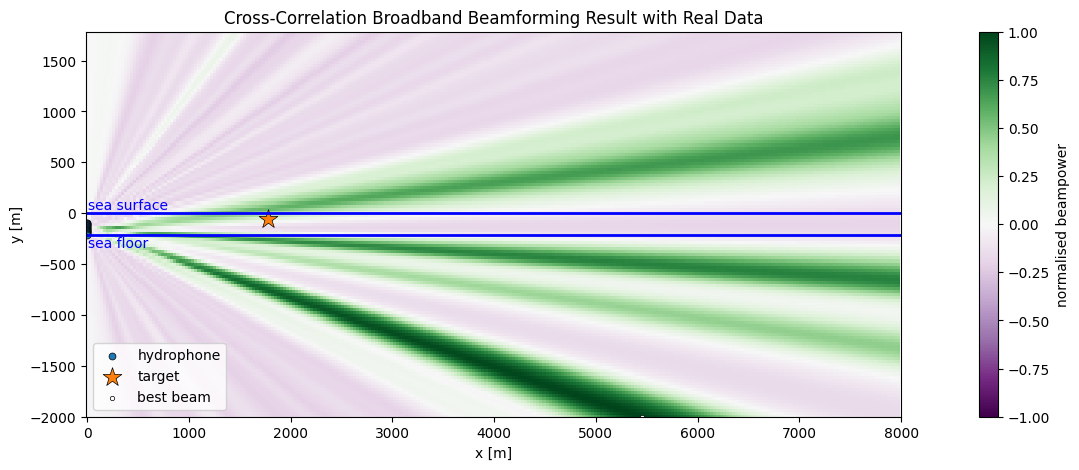

In [13]:
# select a time to plot
plot = 68                                                                           # time to be plotted in minutes (0 - 76)
plot = int(plot * 60 / seconds_per_frame)                                           # convert to frame index

# beamform the data
nbp = NBbeamformMPS(hyd_pos, gridpoints, masked_f_data[plot,:,:], masked_freqs, C)
nbp = nbp.reshape(len(x_grid_coords), len(y_grid_coords), -1)                       # reshape to (x, y, freq)
bbp = nbp.sum(dim=2).real                                                           # sum over frequencies
bbp /= abs(bbp).max()                                                               # normalise beampower to max value
bbp = bbp.cpu()                                                                     # move to CPU and convert to numpy for plotting

F = nbp.shape[2]                                                                    # number of frequency bins used for beamforming

# plot the result
fig1, ax = plt.subplots(figsize =(12, 5))

x, y = targ_pos[plot,:].cpu().T
pcm = ax.pcolormesh(xx, yy, bbp.T, cmap="PRGn", vmin=-1, vmax=1)
ax.scatter(*hyd_pos.cpu().T, marker=".", s=100, label="hydrophone", ec='k', lw=0.5)
ax.scatter(x, y, marker="*", s=200, label="target", ec='k', lw=0.5)
ax.scatter(
    *gridpoints.cpu()[bbp.argmax()],
    marker="o",
    ec="k",
    lw=0.5,
    c="w",
    s=10,
    label="best beam",
)

plt.colorbar(pcm, label="normalised beampower")
ax.axhline(y=-bottom_dep, color='blue', linestyle='-', linewidth=2)
ax.text(x=5, y=-bottom_dep-10, s='sea floor', color='blue', va='top', ha='left')
ax.axhline(y=0, color='blue', linestyle='-', linewidth=2)
ax.text(x=5, y=10, s='sea surface', color='blue', va='bottom', ha='left')
ax.set_xlim(-10, max_range)
ax.set_ylim(-max_depth, max_depth-bottom_dep)
ax.set_aspect("equal")
ax.legend(loc=3)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("Cross-Correlation Broadband Beamforming Result with Real Data")

# free memory
del bbp, pcm, x, y

Beamform the full dataset with Mac performance shaders acceleration

In [14]:
init = 0                                                                                                # initial frame index
chunk = 1000                                                                                            # chunk size for memory management

nbp_tensor = torch.empty((n_frames, len(x_grid_coords), len(y_grid_coords), F), dtype=torch.float32)    # shape = (n_frames, x_grid_coords, y_grid_coords, n_freqs)

# perform framewise beamforming
for i in tqdm(range(init,n_frames)):
    
    gc.collect()                                                                                        # collect garbage
    torch.mps.empty_cache()                                                                             # free memory before each iteration

    nbp = NBbeamformMPS(hyd_pos, gridpoints, masked_f_data[i,:,:], masked_freqs, C)                     # Narrowband Power Spectrum (NBP) beamforming
    nbp = nbp.reshape(len(x_grid_coords), len(y_grid_coords), -1)                                       # reshape to (x, y, freq)
    nbp_tensor[i,:,:,:] = nbp.cpu()                                                              # move to CPU and store in tensor

# save to disk
torch.save(nbp_tensor, f"narrowband_beamforming_output_frame{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.pt")

# calculate broadband beampower by summing over frequencies
bbp_tensor = nbp_tensor.sum(dim=3).real                                                                 # shape = (n_frames, x_grid_coords, y_grid_coords)

# save to disk
torch.save(bbp_tensor, f"broadband_beamforming_output_frame{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.pt")

# free memory
del nbp
gc.collect()
torch.cuda.synchronize()
torch.mps.synchronize()
torch.cuda.empty_cache()
torch.mps.empty_cache()

100%|██████████| 4500/4500 [14:28<00:00,  5.18it/s]


Animate the dataset

In [15]:
# move data to CPU for plotting
# nbp_tensor and bbp_tensor are already on CPU due to size constraints
hyd_pos = hyd_pos.cpu()
targ_pos = targ_pos.cpu() 
gridpoints = gridpoints.cpu()

bbp_vis = bbp_tensor / abs(bbp_tensor).max()  # normalise beampower to max value for visualisation

# plot beamforming result for current step
fig2, ax = plt.subplots(figsize =(12, 5))

pcm = ax.pcolormesh(xx, yy, bbp_vis[0].T, cmap="PRGn", vmin=-1, vmax=1)
hyds = ax.scatter(*hyd_pos.T, marker=".", s=100, label="hydrophone", ec='k', lw=0.5)
targ = ax.scatter(*targ_pos[0], marker="*", s=200, label="target", ec='k', lw=0.5)
best = ax.scatter(*gridpoints[0], marker="o", ec="k", lw=0.5, c="w", s=10, label="best beam")

#plt.colorbar(pcm, ax=ax, label="normalised beampower")
ax.axhline(y=-bottom_dep, color='blue', linestyle='--', linewidth=2)
ax.text(x=5, y=-bottom_dep-10, s='sea floor', color='blue', va='top', ha='left')
ax.axhline(y=0, color='blue', linestyle='--', linewidth=2)
ax.text(x=5, y=10, s='sea surface', color='blue', va='bottom', ha='left')
ax.set_xlim(-10, max_range)
ax.set_ylim(-max_depth, max_depth - bottom_dep)
ax.set_aspect("equal")
ax.legend(loc=3)
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
time_text = ax.text(0.01, 0.98, "", transform=ax.transAxes,
                    fontsize=12, color='black', va='top', ha='left')

def update(frame):
    pcm.set_array(bbp_vis[frame].T.ravel())
    targ.set_offsets(targ_pos[frame + init])
    best.set_offsets(gridpoints[bbp_vis[frame].argmax()])
    
    # Update timestamp and frame
    current_time = START_DT + datetime.timedelta(seconds=frame * seconds_per_frame)
    time_str = f"Frame {frame:03d} — {current_time.strftime('%Y-%m-%d %H:%M:%S')}"

    # Update the text
    time_text.set_text(time_str)

    return pcm, targ, best, time_text

ani = animation.FuncAnimation(fig2, update, frames=bbp_vis.shape[0], blit=False)

plt.close(fig2)

# Save to mp4
ani.save(f"beamforming_animation{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.mp4", fps=30)

# free memory
del ani, fig2, pcm, hyds, targ, best, time_text
gc.collect()
torch.cuda.synchronize()
torch.mps.synchronize()
torch.cuda.empty_cache()
torch.mps.empty_cache()

Additional Pre-processing is necessary because the Deep source secured transmitting CW and transmitted FM at 3 points; this should be masked from the data set prior to training. The dataset documentation is somewhat lacking, so the times to be masked was determined by viewing the animation.

In [ ]:
try:
    bbp_tensor
    print("using new broadband_beampower_tensor")
except NameError:   
    bbp_tensor = torch.load(f"broadband_beamforming_output_frame{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.pt")
    print("using old broadband_beampower_tensor from file.")
except FileNotFoundError:
    print(f"File Broadband_beamforming_output_frame{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.pt not found. Please run the beamforming code first.")

try:
    nbp_tensor
    print("using new narrowband_beampower_tensor")
except NameError:   
    nbp_tensor = torch.load(f"narrowband_beamforming_output_frame{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.pt")
    print("using old narrowband_beampower_tensor from file.")
except FileNotFoundError:
    print(f"File narrowband_beamforming_output_frame{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.pt not found. Please run the beamforming code first.")

N, X, Y, F = nbp_tensor.shape

try:
    del mask                                                # prevent inadvertent masking due to using the same variable name
except NameError:
    pass                                                    # Variable does not exist, so do nothing

# Create mask that functions for both tensors
# Check if target tonals match the deep source tonals. exclude frames when FM was transmitted, and at the very nearest ranges when sound transmitted to the array via direct path propagation
if torch.equal(target_tonals, deep_source_tonals):
    exclude_frames = set(range(0, 500))                     # First 500 (potentially includes FM chirps)
    exclude_frames.update(range(N - 100, N))                # Last 100 (potentially includes FM chirps)
    exclude_frames.update(range(3493, 3571))                # DP frames (potentially includes FM chirps also)

    mask = torch.ones(N, dtype=torch.bool)
    mask[list(exclude_frames)] = False  # set excluded frames to False
else: mask = torch.ones(bbp_tensor.shape[0], dtype=torch.bool)  # No exclusion mask

# Normalize range and data for regression stability
range_mean = targ_xpos.mean()
range_std = targ_xpos.std()
range_norm = (targ_xpos - range_mean) / range_std
bbeam_norm = (bbp_tensor - bbp_tensor.mean()) / bbp_tensor.std()
nbeam_norm = (nbp_tensor - nbp_tensor.mean()) / nbp_tensor.std()


using new broadband_beampower_tensor
using new narrowband_beampower_tensor


Function to pad the input tensor to be divisible by 4; mac performance shadders is not yet compatable with adaptive pooling

In [17]:

def pad_to_multiple(x, multiple=4):
    """
    Pads tensor spatially (H, W) to make both dimensions divisible by `multiple`.
    
    Args:
        x: input tensor of shape (B, C, H, W)
        multiple: integer to pad up to nearest multiple (default: 4)
        
    Returns:
        padded tensor, and the (pad_left, pad_right, pad_top, pad_bottom) used
    """
    _, _, h, w = x.shape
    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple

    # Evenly distribute padding (bottom and right biased if odd)
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    padding = (pad_left, pad_right, pad_top, pad_bottom)
    x_padded = Func.pad(x, padding, mode='reflect')  # or 'constant', 'replicate'

    return x_padded, padding

def pad_to_multiple_3d(x, multiple=4):
    """
    Pad a 5D tensor (B, C, T, H, W) so that H and W are multiples of `multiple`.
    Time (T) is assumed to be already aligned and is left unchanged.
    """
    _, _, _, h, w = x.shape

    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple

    # Padding format for F.pad: (pad_w_left, pad_w_right, pad_h_left, pad_h_right)
    # We pad only height and width (last two dims)
    padding = (0, pad_w, 0, pad_h, 0, 0)  # No padding for T (time)

    x_padded = Func.pad(x, padding, mode="constant", value=0)
    return x_padded, padding


Subdivide and mask dataset without grouping windows

In [18]:

class BBBeamformRangeDataset(Dataset):
    def __init__(self, X, y, mask=None):
        if mask is not None:
            self.indices = mask.nonzero(as_tuple=True)[0]
        else:
            self.indices = torch.arange(X.shape[0])
        
        self.X = X[self.indices].unsqueeze(1).float()  # [N, 1, H, W]
        self.y = y[self.indices].unsqueeze(1).float()  # [N, 1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class BeamCNN(nn.Module):
    def __init__(self, kernel_sizes, hidden_dim , dropout, H, W, activation=nn.ReLU()):
        super().__init__()
        k1, k2 = kernel_sizes

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=k1, stride=2), activation(),
            nn.Conv2d(16, 32, kernel_size=k2, stride=2), activation(),
            nn.AvgPool2d(kernel_size=4, stride=4)
            #nn.AdaptiveAvgPool2d((H //4, W //4))  # incompatable with MPS backend
        )

        flattened_dim = self._get_flatten_size(H, W)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_dim, hidden_dim), activation(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )

    def _get_flatten_size(self, H, W):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, H, W)
            dummy_input, _ = pad_to_multiple(dummy_input, multiple=4) # pad to multiple of 4 for compatibility with unadaptive pool
            out = self.cnn(dummy_input)
            return out.view(1, -1).shape[1]

    def forward(self, x):
        x = self.cnn(x)
        return self.fc(x)

# Get valid indices (non-excluded)
valid_indices = mask.nonzero(as_tuple=True)[0]

# Randomly split into train and val (e.g., 90/10)
train_idx, val_idx = train_test_split(valid_indices, test_size=0.1, random_state=42)

# Create full-length masks
train_mask = torch.zeros(N, dtype=torch.bool)
val_mask = torch.zeros(N, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True

# Create datasets and dataloaders
train_dataset = BBBeamformRangeDataset(bbeam_norm, range_norm, mask=train_mask)
val_dataset   = BBBeamformRangeDataset(bbeam_norm, range_norm, mask=val_mask)
ani_dataset = BBBeamformRangeDataset(bbeam_norm, range_norm, mask=None)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
ani_loader = DataLoader(ani_dataset, batch_size=1, shuffle=False)


Train/Validate using 2D CNN

Epochs: 100%|██████████| 300/300 [04:32<00:00,  1.10epoch/s, MAE_meters=99.3, train=1.44, val=0.322]


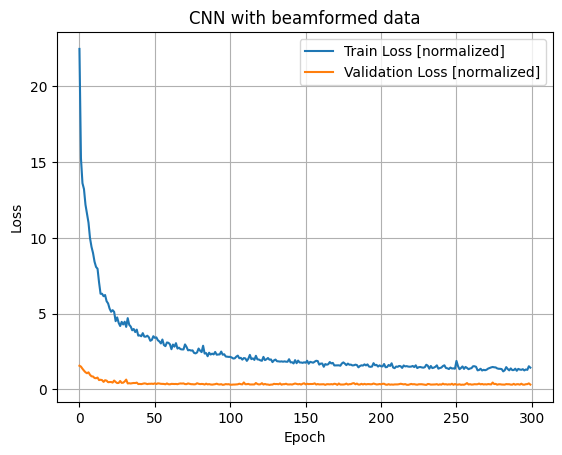

Final MAE on validation set: 99.30 meters


In [ ]:
# Hyper parameters
epochs = 300
learning_rate = 1e-3
hidden_dim = 64
kernel_sizes = (5, 3)
dropout = 0.2

model = BeamCNN(kernel_sizes=kernel_sizes, hidden_dim=hidden_dim, dropout=dropout, H=Y, W=X, activation=nn.GELU)

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = nn.MSELoss()
model = model.to(device)

train_losses = []
val_losses = []

loop = tqdm(range(epochs), desc="Epochs", unit="epoch")
for epoch in loop:

    # training
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        xb, _ = pad_to_multiple(xb, multiple=4)  # padding applied
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    train_losses.append(total_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb, _ = pad_to_multiple(xb, multiple=4)  # padding applied
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_val_loss += loss.item()

            # Unnormalize to get real-world units (meters)
            pred_real = pred * range_std + range_mean
            yb_real = yb * range_std + range_mean

            # Compute mean absolute error (in meters)
            mae_real = torch.mean(torch.abs(pred_real - yb_real)).item()
    
    val_losses.append(total_val_loss)
    loop.set_postfix(train=total_train_loss, val=total_val_loss, MAE_meters=mae_real)

plt.plot(train_losses, label="Train Loss [normalized]")
plt.plot(val_losses, label="Validation Loss [normalized]")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("CNN with beamformed data")
plt.grid(True)
plt.show()

print(f"Final MAE on validation set: {mae_real:.2f} meters")

torch.save(model.state_dict(), "broadband_beamforming_cnn_model.pt")

# Free memory
del optimizer, loss_fn, train_loader, val_loader, train_dataset, val_dataset
gc.collect()
torch.cuda.synchronize()
torch.mps.synchronize()
torch.cuda.empty_cache()
torch.mps.empty_cache()

In [20]:

predicted_ranges = []

model.eval()
with torch.no_grad():
    for x, _ in ani_loader:
        pred = model(x.to(device))  # or x if model is on CPU
        predicted_ranges.append(pred.item())  # scalar per timestep

predicted_ranges = torch.tensor(predicted_ranges) * range_std + range_mean  # unnormalize to meters

# Free memory
del x, pred, ani_loader, ani_dataset
gc.collect()
torch.cuda.synchronize()
torch.mps.synchronize()
torch.cuda.empty_cache()
torch.mps.empty_cache()

Text(0.5, 1.0, 'Cross-correlation beamforming result with real data')

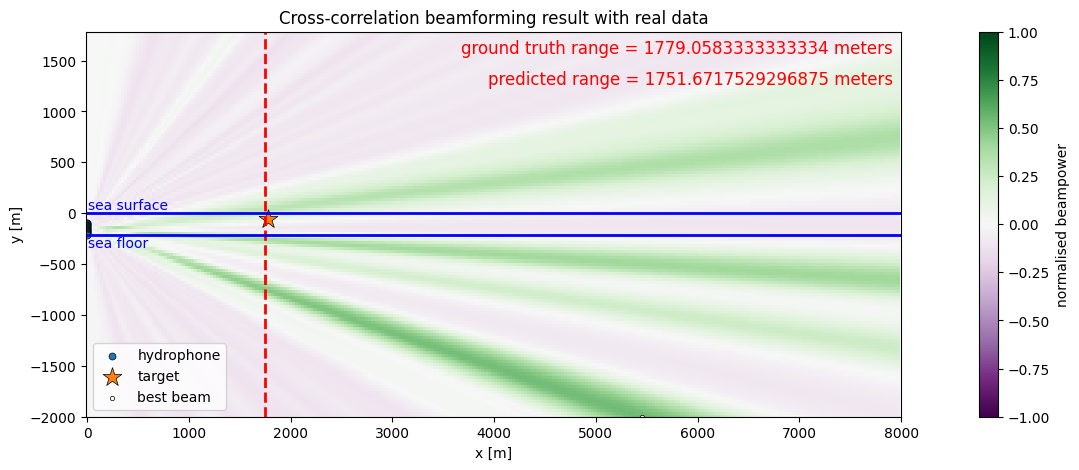

In [ ]:
# select a time to plot
plot = 68                                                                           # time to be plotted in minutes (0 - 76)
plot = int(plot * 60 / seconds_per_frame)                                           # convert to frame index

fig3, ax = plt.subplots(figsize =(12, 5))

xt, yt = targ_pos[plot,:].T
pcm = ax.pcolormesh(xx, yy, bbp_vis[plot].T, cmap="PRGn", vmin=-1, vmax=1)
ax.scatter(*hyd_pos.T, marker=".", s=100, label="hydrophone", ec='k', lw=0.5)
ax.scatter(xt, yt, marker="*", s=200, label="target", ec='k', lw=0.5)
ax.scatter(
    *gridpoints[bbp_vis[plot].argmax()],
    marker="o",
    ec="k",
    lw=0.5,
    c="w",
    s=10,
    label="best beam",
)
ax.axvline(x=predicted_ranges[plot], color='red', linestyle='--', linewidth=2)
ax.text(0.99, 0.98, f"ground truth range = {targ_pos[plot,0]} meters", transform=ax.transAxes,
                    fontsize=12, color='red', va='top', ha='right')
ax.text(0.99, 0.90, f"predicted range = {predicted_ranges[plot]} meters", transform=ax.transAxes,
                    fontsize=12, color='red', va='top', ha='right')


plt.colorbar(pcm, label="normalised beampower")
ax.axhline(y=-bottom_dep, color='blue', linestyle='-', linewidth=2)
ax.text(x=5, y=-bottom_dep-10, s='sea floor', color='blue', va='top', ha='left')
ax.axhline(y=0, color='blue', linestyle='-', linewidth=2)
ax.text(x=5, y=10, s='sea surface', color='blue', va='bottom', ha='left')
ax.set_xlim(-10, max_range)
ax.set_ylim(-max_depth, max_depth-bottom_dep)
ax.set_aspect("equal")
ax.legend(loc=3)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("Cross-correlation beamforming result with real data")

Overlay the range predictions on top of the animation

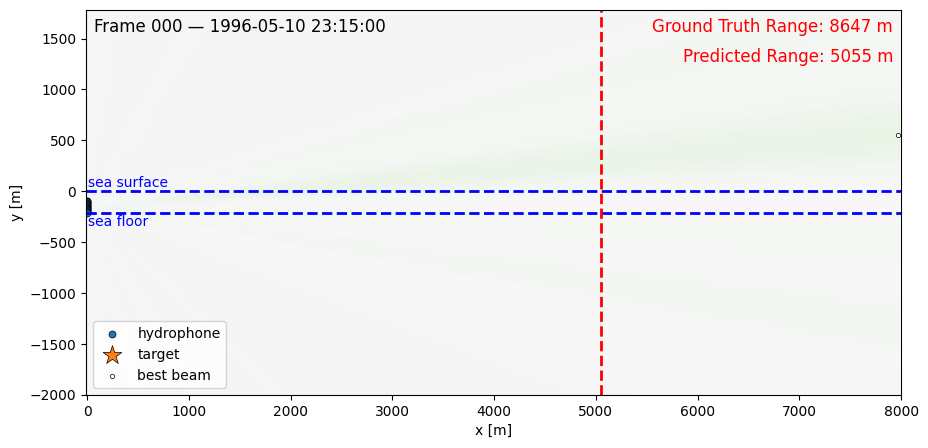

In [ ]:

fig4, ax = plt.subplots(figsize =(12, 5))

pcm = ax.pcolormesh(xx, yy, bbp_vis[0].T, cmap="PRGn", vmin=-1, vmax=1)
hyds = ax.scatter(*hyd_pos.T, marker=".", s=100, label="hydrophone", ec='k', lw=0.5)
targ = ax.scatter(*targ_pos[0], marker="*", s=200, label="target", ec='k', lw=0.5)
best = ax.scatter(*gridpoints[0], marker="o", ec="k", lw=0.5, c="w", s=10, label="best beam")

#plt.colorbar(pcm, ax=ax, label="normalised beampower")
ax.axhline(y=-bottom_dep, color='blue', linestyle='--', linewidth=2)
ax.text(x=5, y=-bottom_dep-10, s='sea floor', color='blue', va='top', ha='left')
ax.axhline(y=0, color='blue', linestyle='--', linewidth=2)
ax.text(x=5, y=10, s='sea surface', color='blue', va='bottom', ha='left')
ax.set_xlim(-10, max_range)
ax.set_ylim(-max_depth, max_depth - bottom_dep)
ax.set_aspect("equal")
ax.legend(loc=3)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
time_text = ax.text(0.01, 0.98, "", transform=ax.transAxes,
                    fontsize=12, color='black', va='top', ha='left')
pred_line = ax.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Predicted Range')
pred_text = ax.text(0.99, 0.90, "", transform=ax.transAxes,
                    fontsize=12, color='red', va='top', ha='right')
gt_text = ax.text(0.99, 0.98, "", transform=ax.transAxes,
                    fontsize=12, color='red', va='top', ha='right')

def update(frame):
    pcm.set_array(bbp_vis[frame].T.ravel())
    targ.set_offsets(targ_pos[frame + init])
    best.set_offsets(gridpoints[bbp_vis[frame].argmax()])

    # Add predicted range overlay
    pred_range = predicted_ranges[frame]
    pred_line.set_xdata([pred_range, pred_range])
    pred_text.set_text(f"Predicted Range: {pred_range:.0f} m")
    
    # Update timestamp and frame
    current_time = START_DT + datetime.timedelta(seconds=frame * seconds_per_frame)
    time_str = f"Frame {frame:03d} — {current_time.strftime('%Y-%m-%d %H:%M:%S')}"

    # Update the text
    time_text.set_text(time_str)
    gt_text.set_text(f"Ground Truth Range: {targ_pos[frame, 0].item():.0f} m")

    return pcm, targ, best, time_text, pred_line, pred_text, gt_text

ani = animation.FuncAnimation(fig4, update, frames=bbp_vis.shape[0], blit=False)

plt.close(fig3)

# Save to mp4 or display
ani.save(f"broadband_beamforming_animation_prediction{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.mp4", fps=30)

# Free memory
del ani, fig4, pcm, hyds, targ, best, time_text, pred_line, pred_text, gt_text
gc.collect()
torch.cuda.synchronize()
torch.mps.synchronize()
torch.cuda.empty_cache()
torch.mps.empty_cache()


In [23]:
class NBBeamformDataset(torch.utils.data.Dataset):
    def __init__(self, nbp_tensor, range_targets, mask):
        self.X = nbp_tensor[mask]  # shape [N_valid, X, Y, F]
        self.y = range_targets[mask]

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx].permute(2, 0, 1).unsqueeze(0)  # [1, F, X, Y]
        return x.float(), self.y[idx].float()

class BeamCNN3D(nn.Module):
    def __init__(self, kernel_sizes, hidden_dim, dropout, H, W, F, activation=nn.ReLU):
        super().__init__()

        k1, k2 = kernel_sizes  # Each kernel is a (T, H, W) tuple
        self.activation = activation()

        self.cnn = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=k1, stride=(1, 2, 2)), self.activation,
            nn.Conv3d(16, 32, kernel_size=k2, stride=(1, 2, 2)), self.activation
        )

        # We'll use avg pooling manually after CNN blocks
        self.pool_kernel = (1, 4, 4)
        self.pool_stride = (1, 4, 4)

        self.flattened_dim = self._get_flatten_size(F, H, W)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_dim, hidden_dim), self.activation,
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )

    def _get_flatten_size(self, F, H, W):
        with torch.no_grad():
            dummy = torch.zeros(1, 1, F, H, W)
            dummy, _ = pad_to_multiple_3d(dummy, multiple=4)
            out = self.cnn(dummy)
            # apply 2D pooling across time slices
            out = self._avgpool_2d_over_time(out)
            return out.reshape(1, -1).shape[1]

    def _avgpool_2d_over_time(self, x):
        # x: [B, C, T, H, W] → (B*T, C, H, W)
        B, C, F, H, W = x.shape
        x = x.permute(0, 2, 1, 3, 4).reshape(B * F, C, H, W)
        x = Func.avg_pool2d(x, kernel_size=self.pool_kernel[1:], stride=self.pool_stride[1:])
        # Back to [B, C, T, H', W']
        x = x.reshape(B, F, C, x.shape[-2], x.shape[-1]).permute(0, 2, 1, 3, 4)
        return x

    def forward(self, x):
        x = self.cnn(x)                        # [B, C, T, H, W]
        x = self._avgpool_2d_over_time(x)     # [B, C, T, H', W']
        return self.fc(x)                     # → regression output

# Recycle the mask fromt the 2D CNN dataset

# Create datasets and dataloaders
nb_train_dataset = NBBeamformDataset(nbeam_norm, range_norm, mask=train_mask)
nb_val_dataset   = NBBeamformDataset(nbeam_norm, range_norm, mask=val_mask)
nb_ani_dataset = NBBeamformDataset(nbeam_norm, range_norm, mask=None)

nb_train_loader = DataLoader(nb_train_dataset, batch_size=32, shuffle=True)
nb_val_loader   = DataLoader(nb_val_dataset, batch_size=32, shuffle=False)
nb_ani_loader = DataLoader(nb_ani_dataset, batch_size=1, shuffle=False)

In [ ]:
# Hyper parameters
epochs = 50
learning_rate = 1e-3
hidden_dim = 32
kernel_sizes = [(3, 3, 3),(3, 3, 3)]  # 2 kernels for 3D conv (freq, height, width)
dropout = 0.2

model2 = BeamCNN3D(kernel_sizes=kernel_sizes, hidden_dim=hidden_dim, dropout=dropout, F=F, H=Y, W=X, activation=nn.GELU)

optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
model2 = model2.to(device)

train_losses = []
val_losses = []

loop = tqdm(range(epochs), desc="Epochs", unit="epoch")
for epoch in loop:
    model2.train()
    total_train_loss = 0

    for xb, yb in nb_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        xb, _ = pad_to_multiple_3d(xb, multiple=4)  # optional for compatibility

        pred = model2(xb)
        loss = loss_fn(pred.squeeze(-1), yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
    train_losses.append(total_train_loss)

    # Validation
    model2.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in nb_val_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb, _ = pad_to_multiple_3d(xb, multiple=4)

            pred = model2(xb)
            loss = loss_fn(pred.squeeze(-1), yb)
            total_val_loss += loss.item()

            # Unnormalize to real-world units (meters)
            pred_real = pred * range_std + range_mean
            yb_real = yb * range_std + range_mean

            mae_real = torch.mean(torch.abs(pred_real - yb_real)).item()

    val_losses.append(total_val_loss)
    loop.set_postfix(train=total_train_loss, val=total_val_loss, MAE_meters=mae_real)

# Plot results
plt.plot(train_losses, label="Train Loss [normalized]")
plt.plot(val_losses, label="Validation Loss [normalized]")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("3D CNN with narrowband beamformed data")
plt.grid(True)
plt.show()

print(f"Final MAE on validation set: {mae_real:.2f} meters")

torch.save(model2.state_dict(), "narrowband_beamforming_cnn_model.pt")

# Free memory
del optimizer, loss_fn, nb_train_loader, nb_val_loader, nb_train_dataset, nb_val_dataset
gc.collect()
torch.cuda.synchronize()
torch.mps.synchronize()
torch.cuda.empty_cache()
torch.mps.empty_cache()

Epochs:  44%|████▍     | 22/50 [50:52<1:04:33, 138.35s/epoch, MAE_meters=303, train=14.1, val=1.02]

In [ ]:
torch.save(model.state_dict(), "broadband_beamforming_cnn_model.pt")
torch.save(model2.state_dict(), "narrowband_beamforming_cnn_model.pt")

In [ ]:

predicted_ranges = []

model2.eval()
with torch.no_grad():
    for x, _ in nb_ani_loader:
        pred = model2(x.to(device))  # or x if model is on CPU
        predicted_ranges.append(pred.item())  # scalar per timestep

predicted_ranges = torch.tensor(predicted_ranges) * range_std + range_mean  # unnormalize to meters

# Free memory
del x, pred, nb_ani_loader, nb_ani_dataset
gc.collect()
torch.cuda.synchronize()
torch.mps.synchronize()
torch.cuda.empty_cache()
torch.mps.empty_cache()

Text(0.5, 1.0, 'Cross-correlation beamforming result with real data')

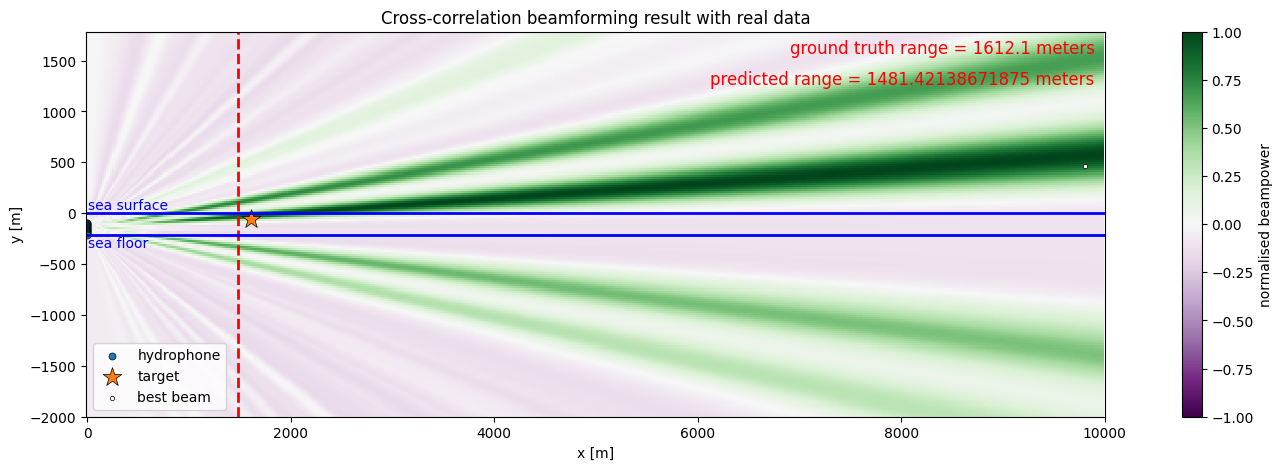

In [ ]:
# select a time to plot
plot = 68                                                                           # time to be plotted in minutes (0 - 76)
plot = int(plot * 60 / seconds_per_frame)                                           # convert to frame index

fig3, ax = plt.subplots(figsize =(12, 5))

xt, yt = targ_pos[plot,:].T
pcm = ax.pcolormesh(xx, yy, bbp_vis[plot].T, cmap="PRGn", vmin=-1, vmax=1)
ax.scatter(*hyd_pos.T, marker=".", s=100, label="hydrophone", ec='k', lw=0.5)
ax.scatter(xt, yt, marker="*", s=200, label="target", ec='k', lw=0.5)
ax.scatter(
    *gridpoints[bbp_vis[plot].argmax()],
    marker="o",
    ec="k",
    lw=0.5,
    c="w",
    s=10,
    label="best beam",
)
ax.axvline(x=predicted_ranges[plot], color='red', linestyle='--', linewidth=2)
ax.text(0.99, 0.98, f"ground truth range = {targ_pos[plot,0]} meters", transform=ax.transAxes,
                    fontsize=12, color='red', va='top', ha='right')
ax.text(0.99, 0.90, f"predicted range = {predicted_ranges[plot]} meters", transform=ax.transAxes,
                    fontsize=12, color='red', va='top', ha='right')


plt.colorbar(pcm, label="normalised beampower")
ax.axhline(y=-bottom_dep, color='blue', linestyle='-', linewidth=2)
ax.text(x=5, y=-bottom_dep-10, s='sea floor', color='blue', va='top', ha='left')
ax.axhline(y=0, color='blue', linestyle='-', linewidth=2)
ax.text(x=5, y=10, s='sea surface', color='blue', va='bottom', ha='left')
ax.set_xlim(-10, max_range)
ax.set_ylim(-max_depth, max_depth-bottom_dep)
ax.set_aspect("equal")
ax.legend(loc=3)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("Cross-correlation beamforming result with real data")

Python(17687) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


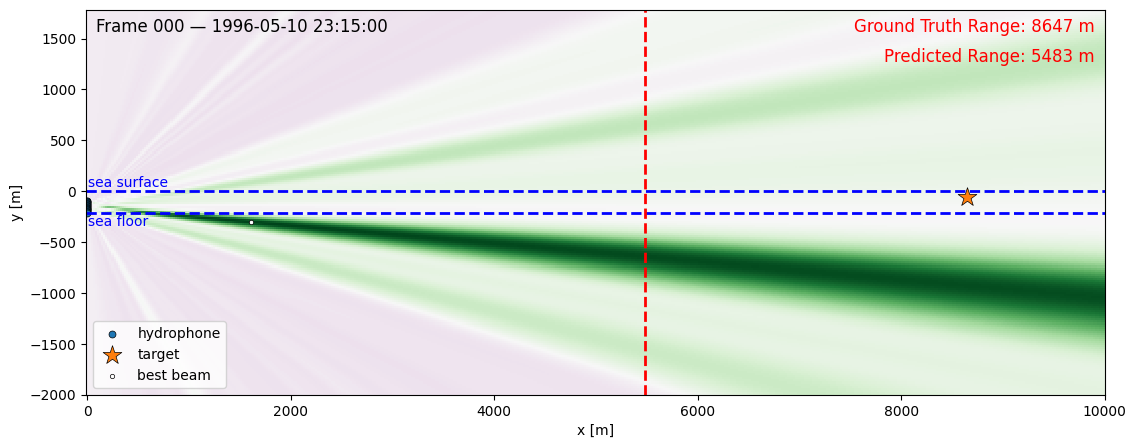

In [ ]:

fig4, ax = plt.subplots(figsize =(12, 5))

pcm = ax.pcolormesh(xx, yy, bbp_vis[0].T, cmap="PRGn", vmin=-1, vmax=1)
hyds = ax.scatter(*hyd_pos.T, marker=".", s=100, label="hydrophone", ec='k', lw=0.5)
targ = ax.scatter(*targ_pos[0], marker="*", s=200, label="target", ec='k', lw=0.5)
best = ax.scatter(*gridpoints[0], marker="o", ec="k", lw=0.5, c="w", s=10, label="best beam")

#plt.colorbar(pcm, ax=ax, label="normalised beampower")
ax.axhline(y=-bottom_dep, color='blue', linestyle='--', linewidth=2)
ax.text(x=5, y=-bottom_dep-10, s='sea floor', color='blue', va='top', ha='left')
ax.axhline(y=0, color='blue', linestyle='--', linewidth=2)
ax.text(x=5, y=10, s='sea surface', color='blue', va='bottom', ha='left')
ax.set_xlim(-10, max_range)
ax.set_ylim(-max_depth, max_depth - bottom_dep)
ax.set_aspect("equal")
ax.legend(loc=3)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
time_text = ax.text(0.01, 0.98, "", transform=ax.transAxes,
                    fontsize=12, color='black', va='top', ha='left')
pred_line = ax.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Predicted Range')
pred_text = ax.text(0.99, 0.90, "", transform=ax.transAxes,
                    fontsize=12, color='red', va='top', ha='right')
gt_text = ax.text(0.99, 0.98, "", transform=ax.transAxes,
                    fontsize=12, color='red', va='top', ha='right')

def update(frame):
    pcm.set_array(bbp_vis[frame].T.ravel())
    targ.set_offsets(targ_pos[frame + init])
    best.set_offsets(gridpoints[bbp_vis[frame].argmax()])

    # Add predicted range overlay
    pred_range = predicted_ranges[frame]
    pred_line.set_xdata([pred_range, pred_range])
    pred_text.set_text(f"Predicted Range: {pred_range:.0f} m")
    
    # Update timestamp and frame
    current_time = START_DT + datetime.timedelta(seconds=frame * seconds_per_frame)
    time_str = f"Frame {frame:03d} — {current_time.strftime('%Y-%m-%d %H:%M:%S')}"

    # Update the text
    time_text.set_text(time_str)
    gt_text.set_text(f"Ground Truth Range: {targ_pos[frame, 0].item():.0f} m")

    return pcm, targ, best, time_text, pred_line, pred_text, gt_text

ani = animation.FuncAnimation(fig4, update, frames=bbp_vis.shape[0], blit=False)

plt.close(fig3)

# Save to mp4 or display
ani.save(f"broadband_beamforming_animation_prediction{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.mp4", fps=30)

# Free memory
del ani, fig4, pcm, hyds, targ, best, time_text, pred_line, pred_text, gt_text
gc.collect()
torch.cuda.synchronize()
torch.mps.synchronize()
torch.cuda.empty_cache()
torch.mps.empty_cache()


Subdivide and mask temporally grouped windows

In [461]:
class BeamformingGroupDataset(torch.utils.data.Dataset):
    def __init__(self, beam_tensor, range_targets, valid_mask, group_size, stride):
        """
        beam_tensor: shape [T, H, W]
        range_targets: shape [T] or [T, 1]
        valid_mask: shape [T] (bool)
        """
        self.beam_tensor = beam_tensor
        self.range_targets = range_targets
        self.valid_mask = valid_mask
        self.group_size = group_size
        self.stride = stride

        # Precompute valid start indices
        self.valid_indices = self._compute_valid_indices()

    def _compute_valid_indices(self):
        T = self.beam_tensor.shape[0]
        indices = []
        for start in range(0, T - self.group_size + 1, self.stride):
            end = start + self.group_size
            if self.valid_mask[start:end].all():
                indices.append(start)
        return indices

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        start = self.valid_indices[idx]
        end = start + self.group_size

        x = self.beam_tensor[start:end]  # shape [group_size, H, W]
        y = self.range_targets[start:end].mean()  # or just y[start + group_size // 2]

        return x.unsqueeze(0), y  # Add channel dim if needed

valid_mask = range_norm.float()

# Train/Val split
n_frames = bbeam_norm.shape[0]
split_ratio = 0.8
n_train = int(n_frames * split_ratio)

train_tensor = bbeam_norm.float()[:n_train]
val_tensor = bbeam_norm.float()[n_train:]

train_targets = range_norm.float()[:n_train]
val_targets = range_norm.float()[n_train:]

train_mask = valid_mask[:n_train]
val_mask = valid_mask[n_train:]

group_size = 10    #number of windows to be grouped together
stride = 1  # stride for grouping

wn_train_dataset = BeamformingGroupDataset(train_tensor, train_targets, train_mask, group_size, stride)
wn_val_dataset = BeamformingGroupDataset(val_tensor, val_targets, val_mask, group_size, stride)

wn_train_loader = torch.utils.data.DataLoader(wn_train_dataset, batch_size=32, shuffle=True)
wn_val_loader = torch.utils.data.DataLoader(wn_val_dataset, batch_size=32, shuffle=False)

Now try convoluting across time too using a 3d CNN

Epochs: 100%|██████████| 10/10 [23:08<00:00, 138.80s/epoch, MAE_meters=242, train=9.08, val=3.15]


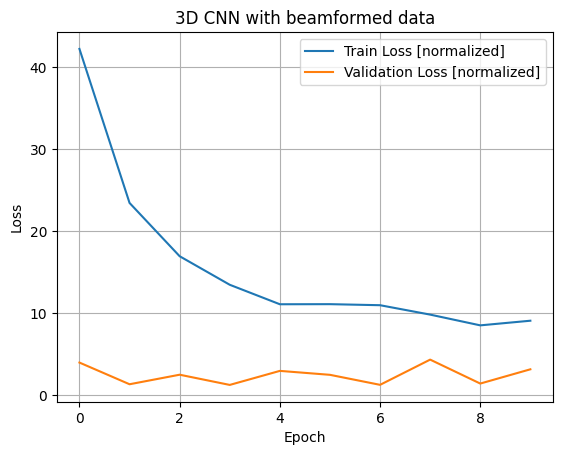

Final MAE on validation set: 241.69 meters


In [464]:
# Hyper parameters
epochs = 50
learning_rate = 1e-3
hidden_dim = 32
kernel_sizes = [(3, 3, 3),(3, 3, 3)]  # 2 kernels for 3D conv (time, height, width)
dropout = 0.3
T = group_size  # number of time steps in each group

model3 = BeamCNN3D(kernel_sizes=kernel_sizes, hidden_dim=hidden_dim, dropout=dropout,
                  F=T, H=Y, W=X, activation=nn.GELU)

optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
model3 = model3.to(device)

train_losses = []
val_losses = []

loop = tqdm(range(epochs), desc="Epochs", unit="epoch")
for epoch in loop:
    model3.train()
    total_train_loss = 0

    for xb, yb in wn_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        xb, _ = pad_to_multiple_3d(xb, multiple=4)  # optional for compatibility

        pred = model3(xb)
        loss = loss_fn(pred.squeeze(-1), yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
    train_losses.append(total_train_loss)

    # Validation
    model3.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in wn_val_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb, _ = pad_to_multiple_3d(xb, multiple=4)

            pred = model3(xb)
            loss = loss_fn(pred.squeeze(-1), yb)
            total_val_loss += loss.item()

            # Unnormalize to real-world units (meters)
            pred_real = pred * range_std + range_mean
            yb_real = yb * range_std + range_mean

            mae_real = torch.mean(torch.abs(pred_real - yb_real)).item()

    val_losses.append(total_val_loss)
    loop.set_postfix(train=total_train_loss, val=total_val_loss, MAE_meters=mae_real)

# Plot results
plt.plot(train_losses, label="Train Loss [normalized]")
plt.plot(val_losses, label="Validation Loss [normalized]")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("3D CNN with beamformed data")
plt.grid(True)
plt.show()

print(f"Final MAE on validation set: {mae_real:.2f} meters")

torch.save(model3.state_dict(), "window_beamforming_cnn_model.pt")

# Free memory
del optimizer, loss_fn, wn_train_loader, wn_val_loader, wn_train_dataset, wn_val_dataset
gc.collect()
torch.cuda.synchronize()
torch.mps.synchronize()
torch.cuda.empty_cache()
torch.mps.empty_cache()